In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumRegister, ClassicalRegister

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def input_state( circuit, f_in, f_out, n ):
    #""" (n+1)-qubit input state for Grover search. """
    for j in range (n):
        circuit.h( f_in[ j ] )
    circuit.x( f_out )
    circuit.h( f_out )

In [3]:
#""" Circuit that computes the black-box function from f_in to f_out .
def blackbox_U_f (circuit, f_in, f_out, aux, n, exactly_1_3_satformula):

    #Create a circuit that verifies whether a given exactly-1 3-SAT formula is satisfied by the input.
    #The exactly 1 version requires exactly one literal out of every clause to be satisfied .
    num_clauses = len(exactly_1_3_satformula)
    if (num_clauses > 3 ):
        raise ValueError('We only allow at most 3 clauses')

    for (k, clause) in enumerate(exactly_1_3_satformula) :
    # This loop ensures aux[ k ] is 1 if an odd number of literals are true
        for literal in clause :
            if literal > 0:
                circuit.cx( f_in[literal - 1], aux[ k ])
            else :
                circuit.x( f_in[ -literal - 1])
                circuit.cx( f_in[ -literal - 1], aux[ k ])

        # Flip aux[ k ] if all literals are true, using auxiliary qubit
        # (ancilla) aux[ num_clauses ]
        circuit.ccx( f_in[ 0 ], f_in[ 1 ], aux[ num_clauses ])
        circuit.ccx( f_in[ 2 ], aux[ num_clauses ], aux[ k ])
        circuit.ccx( f_in[ 0 ], f_in[ 1 ], aux[ num_clauses ])
        
        # Flip back to reverse state of negative literals and ancilla
        for literal in clause:
            if literal < 0 :
                circuit.x( f_in [-literal -1])
        circuit.barrier()
    
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[ num_clauses ] are 1
    if ( num_clauses == 1 ):
        circuit.cx( aux[ 0 ], f_out[ 0 ])
    elif ( num_clauses == 2 ):
        circuit.ccx( aux[ 0 ], aux[ 1 ], f_out[ 0 ] )
    elif ( num_clauses == 3 ):
        circuit.ccx( aux[ 0 ], aux[ 1 ], aux[ num_clauses])
        circuit.ccx( aux[ 2 ], aux[ num_clauses ], f_out[ 0 ] )
        circuit.ccx( aux[ 0 ], aux[ 1 ], aux[ num_clauses ])
    circuit.barrier()
    
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above .
    for (k , clause) in enumerate(exactly_1_3_satformula) :
        for literal in clause :
            if literal > 0 :
                circuit.cx( f_in[ literal - 1], aux[ k ])
            else:
                circuit.x( f_in[ -literal - 1])
                circuit.cx( f_in[ -literal - 1] , aux[ k ])
        circuit.ccx( f_in[ 0 ], f_in[ 1 ], aux[ num_clauses ])
        circuit.ccx( f_in[ 2 ], aux[ num_clauses ], aux[ k ])
        circuit.ccx( f_in[ 0 ], f_in[ 1 ], aux[ num_clauses ])
        for literal in clause :
            if literal < 0 :
                circuit.x( f_in[ -literal - 1])
        circuit.barrier()

In [4]:
def inversion_about_average( circuit, f_in, n):
    #"""Apply inversion about the average step of Grover's algorithm. """
    # Hadamards everywhere
    for j in range (n):
        circuit.h( f_in[ j ])
    # D matrix : flips the sign of the state |00. . .00> only
    for j in range (n):
        circuit.x( f_in[ j ])
    n_controlled_Z( circuit, [ f_in[ j ] for j in range (n-1)], f_in[ n-1])
    for j in range (n):
        circuit.x( f_in[ j ])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h( f_in[ j ])

In [5]:
def n_controlled_Z( circuit, controls, target):
    #""" Implement a Z gate with multiple controls """
    if( len (controls) > 2 ):
        raise ValueError( 'The controlled Z with more than 2 ' + 'controls is not implemented')
    elif( len( controls ) == 1 ):
        circuit.h(target)
        circuit.cx(controls[ 0 ], target)
        circuit.h(target)
    elif( len(controls) == 2):
        circuit.h(target)
        circuit.ccx( controls[ 0 ], controls[ 1 ], target)
        circuit.h( target )

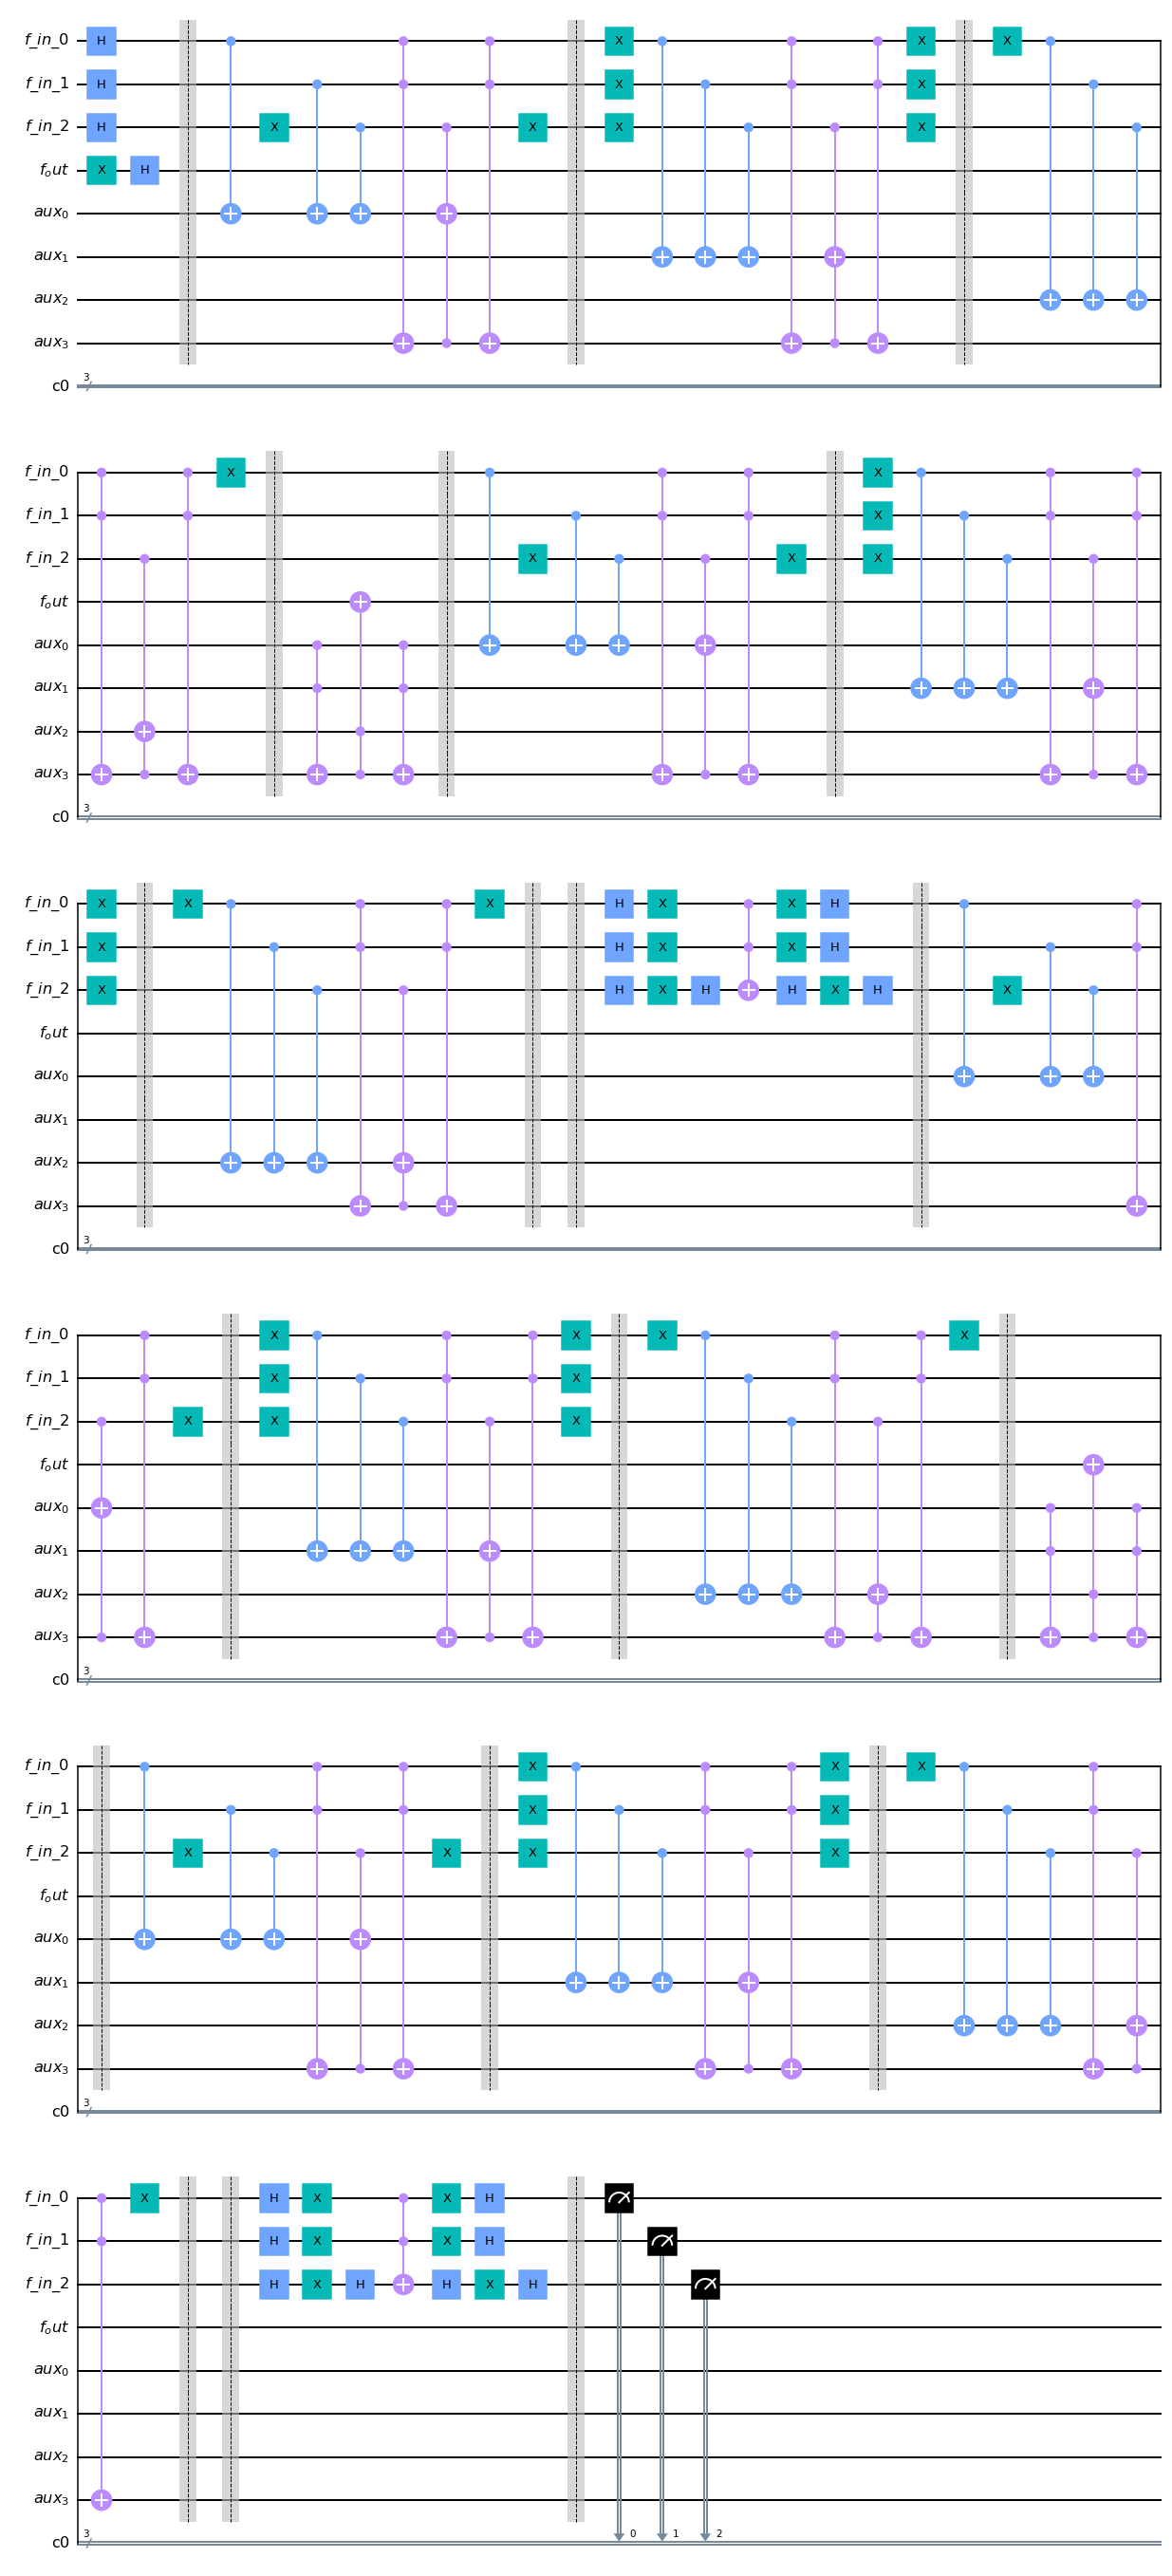

In [6]:
# Make a quantum program for the n-bit Grover search.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive normal form CNF.
# We represent literals with integers, positive or negative to indicate a boolean variable or it's negation.
exactly_1_3_satformula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers : 'f_in' is the search space (input to the function f),
# 'f_out' is bit used for the output of function f, aux are the auxiliary bits used by f to perform it's computation.
f_in = QuantumRegister (n, name='f_in')
f_out = QuantumRegister (1, name='f_out')
aux = QuantumRegister( len(exactly_1_3_satformula) + 1, name='aux')

# One Classical Register to store the result of a measurement
ans = ClassicalRegister(n)
# Create quantum circuit with the quantum and classical registers defined above
qc = QuantumCircuit( f_in, f_out, aux, ans, name='grover')

input_state(qc, f_in, f_out, n)
#insert a Barrier
qc.barrier()

# Apply two full iterations
blackbox_U_f( qc, f_in, f_out, aux, n, exactly_1_3_satformula)
qc.barrier()
inversion_about_average( qc, f_in, n)
qc.barrier()
blackbox_U_f( qc, f_in, f_out, aux, n, exactly_1_3_satformula)
qc.barrier()
inversion_about_average( qc, f_in, n)
qc.barrier()

# Measure the output register in the computational basis
for j in range (n):
    qc.measure( f_in[ j ], ans[ j ])

qc.draw()

 Observed measurement outcomes : 
 string | count 
  000      18
  001      23
  010      15
  011      17
  100      18
  101      1911
  110      27
  111      19


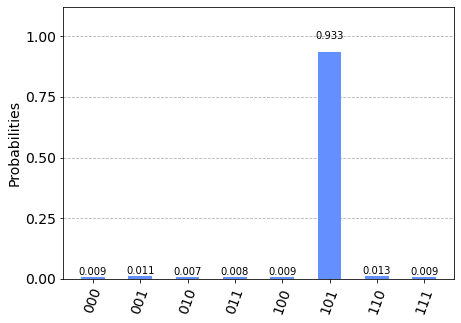

In [7]:
# Create an instance of the local quantum simulator
quantum_simulator = Aer.get_backend ('aer_simulator')

# Execute and store the results.
job = execute(qc, quantum_simulator, shots=2048)
result = job.result( )

# Get counts
counts = result.get_counts()
print( ' Observed measurement outcomes : ' )
print( ' string | count ' )
for key in sorted( counts ):
    print( '{:>5s}      {:d}'.format( key, counts[ key ]))

#figure = plot_histogram( counts )
#figure.show( )
#figure.savefig ( 'groverhist.png ' )
plot_histogram( counts )